# Testing and validation approaches for scientific software

![The perils of floating point](img/floating-point.png)

### Juan Luis Cano - 2018-09-25 OSCW '18 @ ESAC, Madrid

## Duration

12 minutes of talk + 8 minutes of Q&A

## Description

https://2018.oscw.space/event/1/contributions/13/

Nowadays, even though software has a fundamental role in scientific research, the wide majority of scientists is primarily self-taught and received no formal training in software engineering, with often leads to quality and reproducibility problems[1]. The space industry is in a similar situation, with many incident reports describing “various aspects of complacency and a discounting or misunderstanding of the risks associated with software”[2][3].

One of the most useful engineering techniques, **software testing**, is also the one that presents the biggest gap between its perceived importance and the skill level of scientists in it[4]. Testing, as well as other good practices such as version control and code reviews, not only make code more reusable but also increase the productivity of the developer[5]. However, the **special nature of scientific or algorithmic software** makes it difficult to apply commonplace testing practices, since the challenges lie in “separating software bugs from model errors and approximation error”[4].

In this talk we will discuss some testing approaches (or lack thereof) present in scientific software that fall short in helping the developers find errors or increase their productivity, and propose some other strategies based on our experience with poliastro, an open source Python library for Astrodynamics[6]. These strategies make use of **automated testing frameworks**, **help covering test cases in an exhaustive way** (hypotheses), take advantage of **analytical solutions** of the problems at hand or **public data** when available, and guarantee **self consistency** (regression testing) when there is nothing to compare against. Finally, we will analyze the limitations of these approaches and discuss possible solutions.

* [1]: Wilson, Greg, Dhavide A. Aruliah, C. Titus Brown, Neil P. Chue Hong, Matt Davis, Richard T. Guy, Steven HD Haddock et al. "Best practices for scientific computing." PLoS biology 12, no. 1 (2014): e1001745.
* [2]: Leveson, Nancy G. "Role of software in spacecraft accidents." Journal of spacecraft and Rockets 41, no. 4 (2004): 564-575.
* [3]: Lutz, Robyn R. "Analyzing software requirements errors in safety-critical, embedded systems." In Requirements Engineering, 1993., Proceedings of IEEE International Symposium on, pp. 126-133. IEEE, 1993.
* [4]: Hannay, Jo Erskine, Carolyn MacLeod, Janice Singer, Hans Petter Langtangen, Dietmar Pfahl, and Greg Wilson. "How do scientists develop and use scientific software?." In Software Engineering for Computational Science and Engineering, 2009. SECSE'09. ICSE Workshop on, pp. 1-8. Ieee, 2009.
* [5]: Wilson, Greg, Dhavide A. Aruliah, C. Titus Brown, Neil P. Chue Hong, Matt Davis, Richard T. Guy, Steven HD Haddock et al. "Best practices for scientific computing." PLoS biology 12, no. 1 (2014): e1001745.
* [6]: Juan Luis Cano Rodríguez, Antonio Hidalgo, Shreyas Bapat, Nikita Astrakhantsev, Alberto Lorenzo Márquez, Pablo Rodríguez Robles, Ritiek Malhotra, et al. 2018. “Poliastro/poliastro: Poliastro 0.9.1 (pickle Edition)”. Zenodo. doi:10.5281/zenodo.1245650.

# Overview

1. Introduction and motivation
2. Testing, and where it falls short
3. What to validate against?
4. Python testing frameworks
5. The importance of a good API
6. Conclusions

# Who am I?

<img src="img/juanlu_esa.jpg" alt="Me!" width="400" style="float:right"></img>

* **Aerospace Engineer** with a passion for orbits 🛰
* Chair of the **Python España** non profit and co-organizer of **PyCon Spain** 🐍
* **Software Developer** at **Satellogic** 🌍
* Free Software advocate and Python enthusiast 🕮
* Hard Rock lover 🎸

Follow me! https://github.com/Juanlu001/

<div style="clear:both"></div>

# Disclaimer

> This is **not** another talk about poliastro!

But you can check out the latest release (0.11.0, https://groups.io/g/poliastro-dev/message/63) and watch the one from the previous edition online:

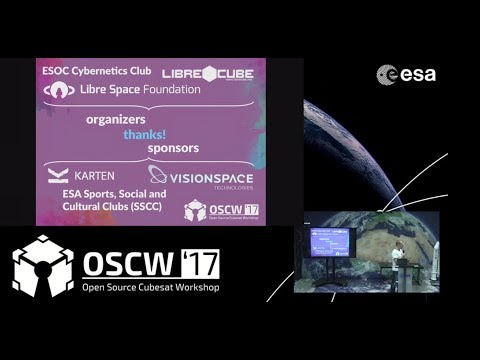

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("KnoYzqAw_vM", start=5774)

## A not so long time ago...

<img src="img/mco.png" alt="Mars Climate Orbiter" width="600" ></img>

# Challenges

## Validation

> Unit testing a function with clear expectations is trivial. What are my expectations on numerical algorithms?

The wrooooooooooooooong way:

In [15]:
def sinc(x):
    return np.sin(x) / x

In [16]:
import pytest

In [17]:
@pytest.mark.parametrize("x", [0, 1, 10])
def test_sinc(x):
    assert sinc(x) == np.sin(x) / x

In [18]:
0.1 + 0.2 == 0.3

False

In [19]:
0.2 + 0.3 == 0.5

True

A better way:

* Compare against some authoritative source: **external data or software**
* Do floating point comparisons right and **use tolerances**

In [2]:
def test_convert_from_rv_to_coe():
    # Data from Vallado, example 2.6
    attractor = Earth
    p = 11067.790 * u.km
    ecc = 0.83285 * u.one
    inc = 87.87 * u.deg
    raan = 227.89 * u.deg
    argp = 53.38 * u.deg
    nu = 92.335 * u.deg
    expected_r = [6525.344, 6861.535, 6449.125] * u.km
    expected_v = [4.902276, 5.533124, -1.975709] * u.km / u.s

    r, v = ClassicalState(attractor, p, ecc, inc, raan, argp, nu).rv()

    assert_quantity_allclose(r, expected_r, rtol=1e-5)
    assert_quantity_allclose(v, expected_v, rtol=1e-5)

What's the perfect way?

* How much precision do you ask for? Should you carry a mathematical analysis?
* What if your results don't match? Sometimes, book or paper authors respond to your comments... And sometimes don't
* The changes in precision are a result of bad data, or worse algorithms?
* How do you even track _improvements_?

### External data (short summary)

* Nobody cares

* Those who care, don't share it

* Those who share, do it with 1 decimal place (true story)

* Those who share with 16 decimal places, don't describe how it was obtained (i.e. release the source)

* Those who release the source, make it impossible to compile

### External software

* Sometimes commercial
* Is it validated itself? (See above)
* It is often difficult to reproduce the exact setting and algorithms, most of the times because your commercial software is much more complex

![Shrug](img/shrugging-guy.jpg)

...If you're really interested, go read my Final Masters Project: https://github.com/juanlu001/pfc-uc3m

## Performant and "for humans"

* _Yes, Python is slow_ (compared to compiled languages)
* Some algorithms cannot easily be vectorized (i.e. replaced by NumPy)
* And even if you can, vectorized code can be impossible to read
* I don't like Cython (messy, impossible to debug, I don't know C)
* _numba helps only with Fortran-esque code_ (forget about closures or introspection)

![Too smart](img/too_smart.png)

So... let's make our code Fortran-esque!

<img src="img/architecture.svg" alt="Architecture" width="500" style="float:right"></img>

High level API:

* Supports mixed units and time scales, figures out the rest
* Easy to use and impossible to get wrong
* **Slow**

Dangerous™ algorithms:

* **Fast** (easy to accelerate with numba or Cython)
* Only cares about numbers, makes assumptions on units (SI, TBD)
* **You can mess it up**

<div style="clear:both"></div>

# _Per Python ad astra!_ 🚀

* Slides: https://github.com/poliastro/oscw2018-talk
* poliastro chat: https://riot.im/app/#/room/#poliastro:matrix.org
* Twitter: https://twitter.com/poliastro_py